### Lighting Science Final Project  <br>
Takehiro Izumi, Amrit Shaw, Takuma Tsuruta <br>


Import necesarry librarieas and try to connect the DMX controller and JETI spectroradiometers.

In [122]:
from DMXEnttecPro import Controller
from DMXEnttecPro.utils import get_port_by_serial_number, get_port_by_product_id
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime
import os
import luxpy as lx  # package for color science calculations
from luxpy.toolboxes import spectro as sp
import glob
from luxpy.toolboxes import spdbuild as spb

cieobs = '1964_10'


class DMXHandler():
    def __init__(self, product_id) -> None:
        self.product_id = product_id
        self.dmx = None
        self.is_connected = False

    def open(self):
        try:
            port = get_port_by_product_id(self.product_id)
            self.dmx = Controller(port)
            print('DMX connected')
            self.is_connected = True
        except:
            self.dmx = None
            print('no DMX connection')
            self.is_connected = False

    def control_channels(self, dr_value_in, channels_idx=[0, 1, 2, 3, 4]):
        # example:  turn on R 100, B 10
        # dmx.control_channels(dr_value_in=[100, 10], channels_idx=[0, 1])
        if len(channels_idx) != len(dr_value_in):
            print('Both input variables should have same length.')

        for (c, v) in zip(channels_idx):
            self.dmx.set_channel(c+1, int(v))
        self.dmx.submit()

    def close(self):
        if self.is_connected:
            dmx.set_channel(1, 0)
            dmx.submit()
            self.dmx.close()


dmx = DMXHandler(24577)

dmx.open()
sp.init('jeti')

no DMX connection


<module 'luxpy.toolboxes.spectro.jeti.jeti' from 'c:\\Users\\robgy\\anaconda3\\lib\\site-packages\\luxpy\\toolboxes\\spectro\\jeti\\jeti.py'>

Turn on the laser pointer in JETI and check the measurement point.

In [123]:
if dmx.is_connected:
    sp.jeti.set_laser(laser_on=True)
    dmx.control_channels(dr_value_in=[0, 0, 0, 0, 0])
    time.sleep(2)
    sp.jeti.set_laser(laser_on=False)


In [124]:

def measureSPD(channels_idx, driver_values):
    if not dmx.is_connected:
        return None
    # Avoid to measure with 0 output value because JETI can't be used in a dark room.
    if np.sum(driver_values) == 0:
        return None
    dmx.control_channels(dr_value_in=driver_values, channels_idx=channels_idx)
    time.sleep(0.2)
    spd = sp.jeti.get_spd()
    return spd


def measureSPDforCalibration(channels_idx, dr_value_in):
    measured_spd_all = []
    for channel in channels_idx:
        measured_spd = []
        for v in dr_value_in:
            print(channel, v)
            spd = measureSPD(dr_value_in=[v], channels_idx=[channel])
            measured_spd.append(spd)

            #  fill None data as zero spectrum
            if measured_spd[0] is None:
                measured_spd[0] = measured_spd[1].copy()
                measured_spd[0][-1] = measured_spd[0][-1]*0

        first_spd = measured_spd[0].copy()
        after_first_spd_intensity = measured_spd[1:, 1, :].copy()
        spd_channel = np.concatenate(
            [first_spd, after_first_spd_intensity], axis=0)
        measured_spd_all.append(spd_channel)

    return measured_spd_all


def calibrate(filename=None):
    # try to load existing calibration data when filename is specified.
    if filename is not None:
        return np.load(filename)

    if not dmx.is_connected:
        print('Connect DMX controller to run calibration.')
        return False

    now = datetime.datetime.now()
    filename = './output/data_' + now.strftime('%Y%m%d_%H%M%S')
    if not os.path.exists(os.path.dirname(filename)):
        os.mkdir(os.path.dirname(filename))

    channels = [0, 1, 2, 3, 4]
    dr_value_in = np.concatenate([np.arange(0, 50, 5), np.arange(50, 255, 10)])
    if dr_value_in[-1] < 255:  # make sure the last output is max.
        dr_value_in = np.append(dr_value_in, 255)

    measured_spd_all = measureSPDforCalibration(channels, dr_value_in)
    np.savez(filename, spd=measured_spd_all,
             dr_value_in=dr_value_in, channels=channels)
    return np.load(filename+'.npz')


Calibrate the light source (or load existing calibrate data). <br>
Calculate output-value v.s. output-luminance characteristic using poly fit function. <br>
Show the graphs if specified (is_plot = True).

In [125]:
# f = 'output/data_20230324_163716.npz'
# f = 'output/data_20230420_104200.npz'
# f = None
f = 'output/_data_20230424_180235.npz'
is_plot = False
# is_plot=True
data = calibrate(f)



In [126]:

dr_value = data['dr_value_in']
# dr_value = data['output_values']
channels = data['channels']
measured_spd_all = data['spd']
labels = ['R', 'G', 'B', 'WH', 'A', 'UV']
print(channels)

# new_measured_spd_all = []
# for channel in channels:
#     first_spd = measured_spd_all[channel][0].copy()
#     after_first_spd_intensity = measured_spd_all[channel][1:, 1, :].copy()
#     spd_channel = np.concatenate(
#         [first_spd, after_first_spd_intensity], axis=0)
#     print(spd_channel.shape)
#     new_measured_spd_all.append(spd_channel)
# measured_spd_all = new_measured_spd_all
normL2drv = []

# newfilename = 'output/_data_20230424_180235.npz'
# np.savez(newfilename, spd=new_measured_spd_all,
#              dr_value_in=dr_value, channels=channels)

for i, channel in enumerate(channels):
    luminance = lx.spd_to_power(
        measured_spd_all[i], ptype='pu', cieobs=cieobs)[:, 0]
    normalized_luminance = (luminance-min(luminance)) / (max(luminance)-min(luminance))

    z = np.polyfit(luminance, dr_value, 6)
    z_norm = np.polyfit(normalized_luminance, dr_value, 6)

    func = np.poly1d(z)
    func_norm = np.poly1d(z_norm)

    normL2drv.append(func_norm)    

    if is_plot:
        plt.figure()
        plt.plot(dr_value, luminance, '.')
        plt.plot(func(luminance), luminance, '-')
        plt.xlabel('driver value indices')
        plt.ylabel('Luminance [cd/m^2]')
        plt.title(labels[i])
        plt.savefig('output/luminance_output_{}.png'.format(labels[i]))

        plt.figure()
        plt.plot(dr_value, normalized_luminance, '.')
        plt.plot(func_norm(normalized_luminance), normalized_luminance, '-')
        plt.xlabel('Output Value')
        plt.ylabel('Normalized Luminance')
        plt.title(labels[i])
        plt.savefig('output/normL_output_{}.png'.format(labels[i]))

        lx.SPD(np.vstack([measured_spd_all[i][0, :].copy(), measured_spd_all[i][-1, :].copy()])).plot()
        plt.title(labels[i])
        plt.savefig('output/spd_255_{}.png'.format(labels[i]))


[0 1 2 3 4]


In [131]:
def getPrimarySPD(channels_idx):
    spd_p = []
    for c in channels_idx:
        spd = np.vstack((measured_spd_all[c, 0, :].copy(), measured_spd_all[c, -1, :].copy()))
        # spd[-1] = spd[-1] - measured_spd_all[c][0][-1]
        spd_p.append(spd)
    return np.vstack([spd_p[0][0]] +
                         [s[-1] for s in spd_p])

def getDriverValues(channels_idx, weights):
    driver_values = []
    for i, w in zip(channels_idx, weights[0]):
        if w <= 0:
            driver_values.append(0)
            print("The weight was negative, so may not achieve accurate result.")
        elif w >= 1:
            driver_values.append(255)
        else:
            v = normL2drv[i](w)
            driver_values.append(v)
    driver_values = np.around(driver_values)
    return np.asarray(driver_values, dtype = np.uint8)



def calculateOptimizedSPD(spd_p, weights):
    weighted_p = spd_p[0:2].copy()
    weighted_p[-1] *= 0
    for i, (p, w) in enumerate(zip(spd_p[1:], weights[0])):
        weighted_p[-1] += p*w
    return weighted_p

def showMixedSPD(spd_p, spd_optimized): #weighted_p is the optimizedspd and spd_p is the primary stacked spd
    fig,ax = plt.subplots(1,2, figsize=(18,6))
    plt.sca(ax[0]); 
    plt.title('Primaries')
    lx.SPD(spd_p).plot()
    plt.sca(ax[1]); 
    plt.title('Mixed SPD for the target')
    lx.SPD(spd_optimized).plot()

def evaluate(spd, xyz_t):
    l = lx.spd_to_power(spd, ptype='pu', cieobs=cieobs)
        
    xyz_obtained = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
    print("Luminance [cd/m2] : {:1.1f}".format(l[0][0]))
    
    print("xyz : [ {0[0]:1.1f}, {0[1]:1.1f}, {0[2]:1.1f} ]".format(xyz_obtained[0]))
    print("Target xyz : [ {0[0]:1.1f}, {0[1]:1.1f}, {0[2]:1.1f} ]".format(xyz_t[0]))
    
    # print((lx.xyz_to_cct(xyz_obtained, cieobs=cieobs, out='cct'))[0])

    cct, duv = lx.xyz_to_cct(xyz_obtained, cieobs=cieobs, out='cct,duv')
    Rf, Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30', out='Rf,Rg')

    print("CCT: {:1.1f}".format(cct[0][0]))
    print("Duv: {:1.5f}".format(duv[0][0]))
    
    print("Rf: {:1.1f}".format(Rf[0][0]))
    print("Rg: {:1.1f}".format(Rg[0][0]))
    print("LER: {:1.1f}".format((lx.spd_to_ler(spd))[0,0]))

    get_color_difference(spd,xyz_t)


    Yuv_obtained = lx.xyz_to_Yuv(xyz_obtained)
    Yuv_target = lx.xyz_to_Yuv(xyz_t)


    
    Y_t, u_t, v_t = lx.utils.asplit(Yuv_target)
    Y, u, v = lx.utils.asplit(Yuv_obtained)
    
    fig, ax = plt.subplots(1,2,figsize=(18,6))


    ax[0].plot(u, v,
            color ='r', marker = 'o', linestyle = 'none', label='obtained')
    ax[0].plot(u_t, v_t,
            color ='b', marker ='d', linestyle = 'none', label='target')
    ax[0].set_xlabel("u'")  # set x-axis label
    ax[0].legend()
    ax[0].set_ylabel("v'")  # set y-axis label
    
    lx.cri.plot_tm30_cvg(spd, axh=ax[1]) # maybe this is not using cieobs=1964_10, so the cct value could be different.

    lx.plotSL(cieobs=cieobs, cspace='Yuv', DL=False,
        BBL=True, diagram_colors=True, axh=ax[0])

def get_color_difference(spd, xyz_t):

    xyz_obtained = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
    
    luv_obt = lx.xyz_to_luv(xyz_obtained)
    luv_tar = lx.xyz_to_luv(xyz_t)

    # Calculate L*u*v* color difference manually:
    DEuv_luv = np.sqrt((luv_tar[0,0] - luv_obt[0,0])**2 + (luv_tar[0,1] - luv_obt[0,1])**2 + (luv_tar[0,2] - luv_obt[0,2])**2 )


    print("color difference in LUV space: {:1.3f}".format(DEuv_luv))
    if DEuv_luv < 0.001:
        print("JND:",0)
    else:
        jnd = int(np.ceil(DEuv_luv/0.006))
        print("JNDs:", jnd)
  

def color_mixing(xyz_t, channels_idx):
    Yxy_t = lx.xyz_to_Yxy(xyz_t)
    spd_p = getPrimarySPD(channels_idx=channels_idx)
    xyz_p = lx.spd_to_xyz(spd_p, relative=False, cieobs=cieobs) # always mention CIE when convert spd to colorimetric value
    Yxy_p = lx.xyz_to_Yxy(xyz_p)

    M_xyz = spb.colormixer_pinv(xyz_t, xyz_p, input_fmt='xyz') 
    # M_Yxy = spb.colormixer_pinv(Yxy_t, Yxy_p, input_fmt='Yxy') 
    M = M_xyz
    driver_values = getDriverValues(channels_idx, M)

    print('Selected channels:', [labels[c] for c in channels_idx])
    print('Optimized primary contributions:', M[0])
    print('driver values of the light source:', driver_values)
    

    print('\n-----------Optimized------------')
    spd_optimized = calculateOptimizedSPD(spd_p, M)
    showMixedSPD(spd_p, spd_optimized)
    evaluate(spd_optimized, xyz_t)
    
    if dmx.is_connected:
        print('\n------------Measured------------')
        spd_measured = measureSPD(channels_idx, driver_values)
        showMixedSPD(spd_p, spd_measured)
        evaluate(spd_measured, xyz_t)

    return spd_optimized


Selected channels: ['R', 'G', 'B']
Optimized primary contributions: [6.9260e-02 5.8817e-02 2.7767e-02]
driver values of the light source: [45 35 14]

-----------Optimized------------
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 100.0 ]
Target xyz : [ 100.0, 100.0, 100.0 ]
CCT: 5482.0
Duv: -0.00414
Rf: 60.6
Rg: 122.6
LER: 268.8
color difference in LUV space: 4.2863236558381085e-14
JND: 0


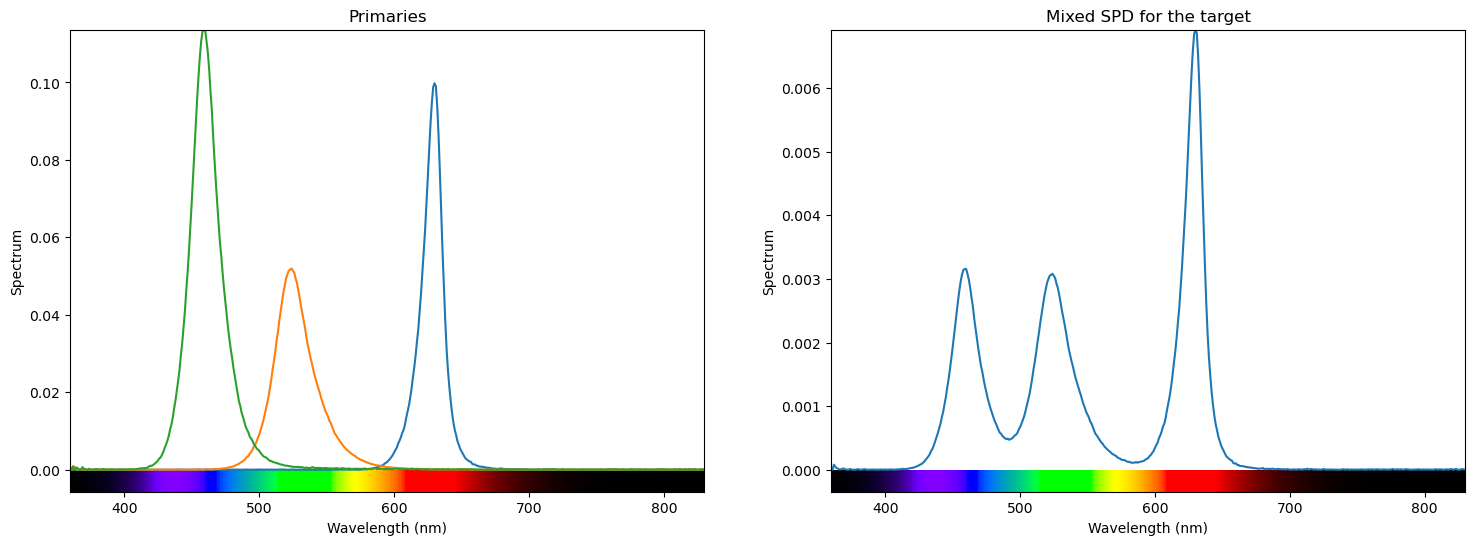

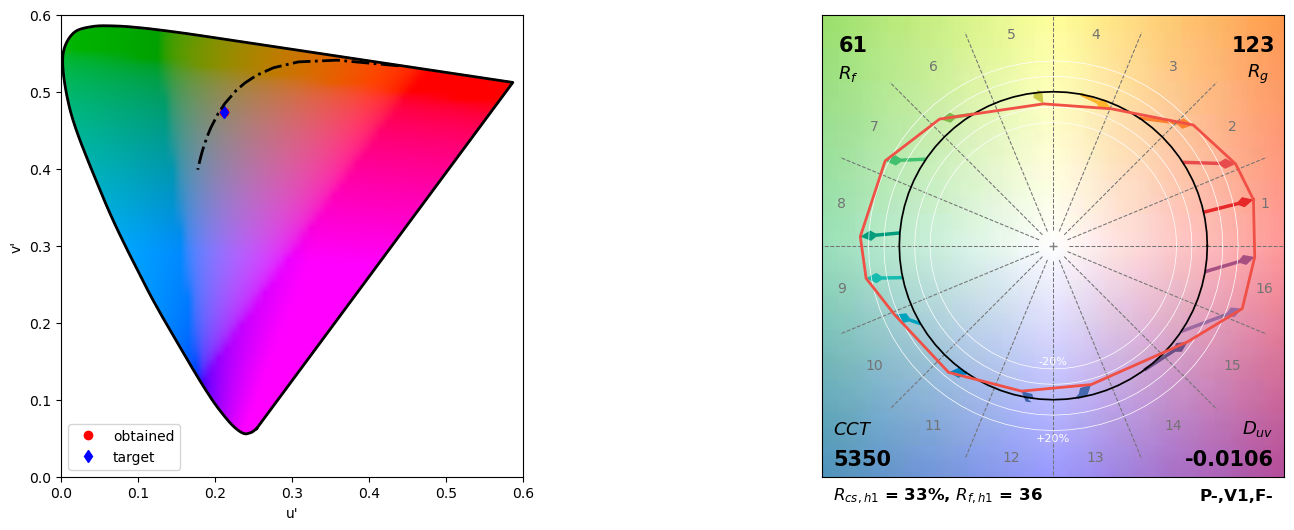

In [132]:
xyz_t = np.array([[100, 100, 100]])*1
channels_idx = [0, 1, 2]
spd3 = color_mixing(xyz_t, channels_idx)

## 4-channels colormixing

Selected channels: ['R', 'G', 'B', 'A']
Optimized primary contributions: [2.4512e-01 2.6916e-01 1.3944e-01 1.7727e-01]
driver values of the light source: [128 136  85  98]

-----------Optimized------------
Luminance [cd/m2] : 500.0
xyz : [ 500.0, 500.0, 500.0 ]
Target xyz : [ 500.0, 500.0, 500.0 ]
[5.4820e+03]
CCT: 5481.998552251271
Duv: -0.0041422889241609145
Rf: 74.03783714256194
Rg: 114.83913788642151
LER: 287.77477411881074
color difference in LUV space: 3.032111563549033e-13
JND: 0


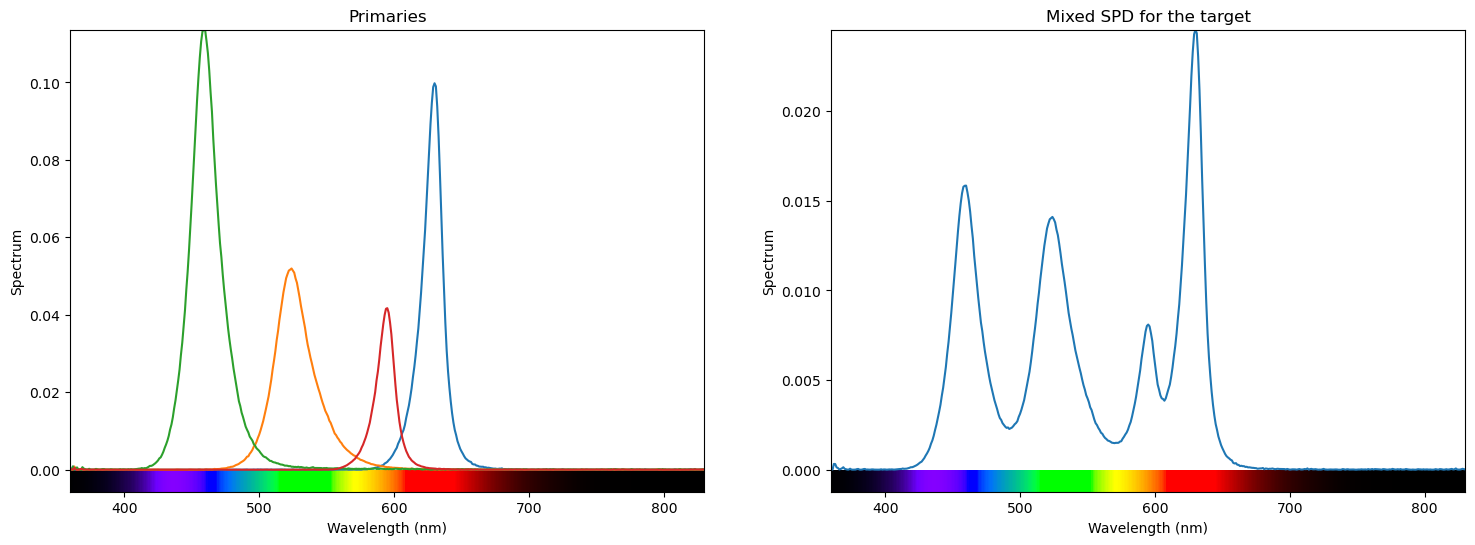

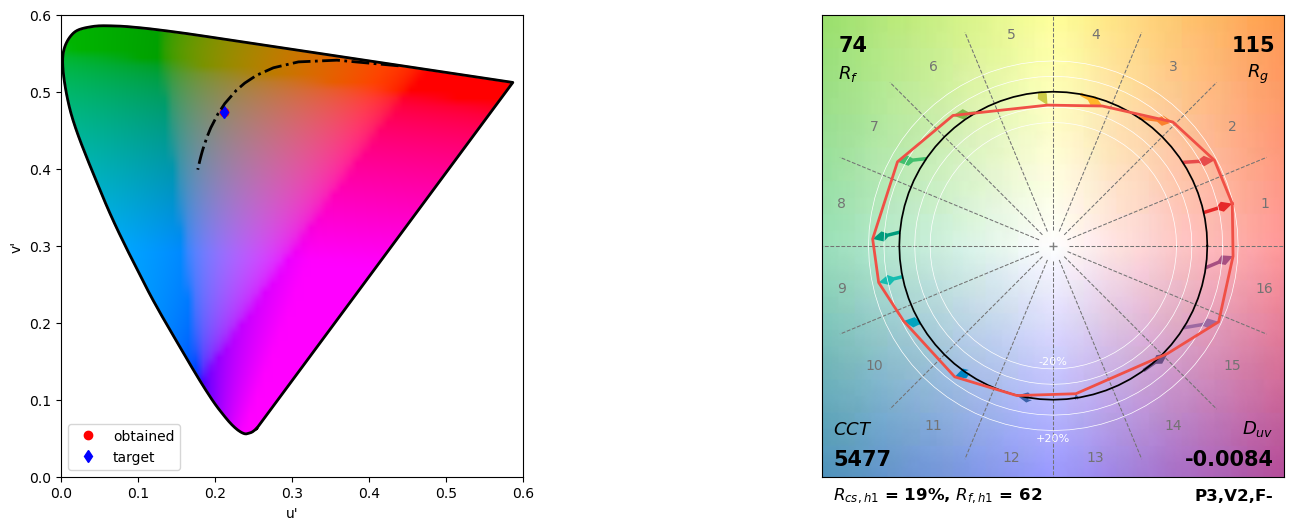

In [ ]:
xyz_t = np.array([[100, 100, 100]])*5
channels_idx = [0, 1, 2, 4]
spd4 = color_mixing(xyz_t,  channels_idx)


### 5 channels mixing

Selected channels: ['R', 'G', 'B', 'WH', 'A']
Optimized primary contributions: [2.9202e-02 3.1522e-02 1.4883e-02 4.2177e-02 2.1048e-02]
driver values of the light source: [16 16  4 25  9]

-----------Optimized------------
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 100.0 ]
Target xyz : [ 100.0, 100.0, 100.0 ]
[5.4820e+03]
CCT: 5481.998552251255
Duv: -0.0041422889241607575
Rf: 87.76803512309235
Rg: 110.97633508870537
LER: 304.5901869421965
color difference in LUV space: 8.60020921103214e-14
JND: 0


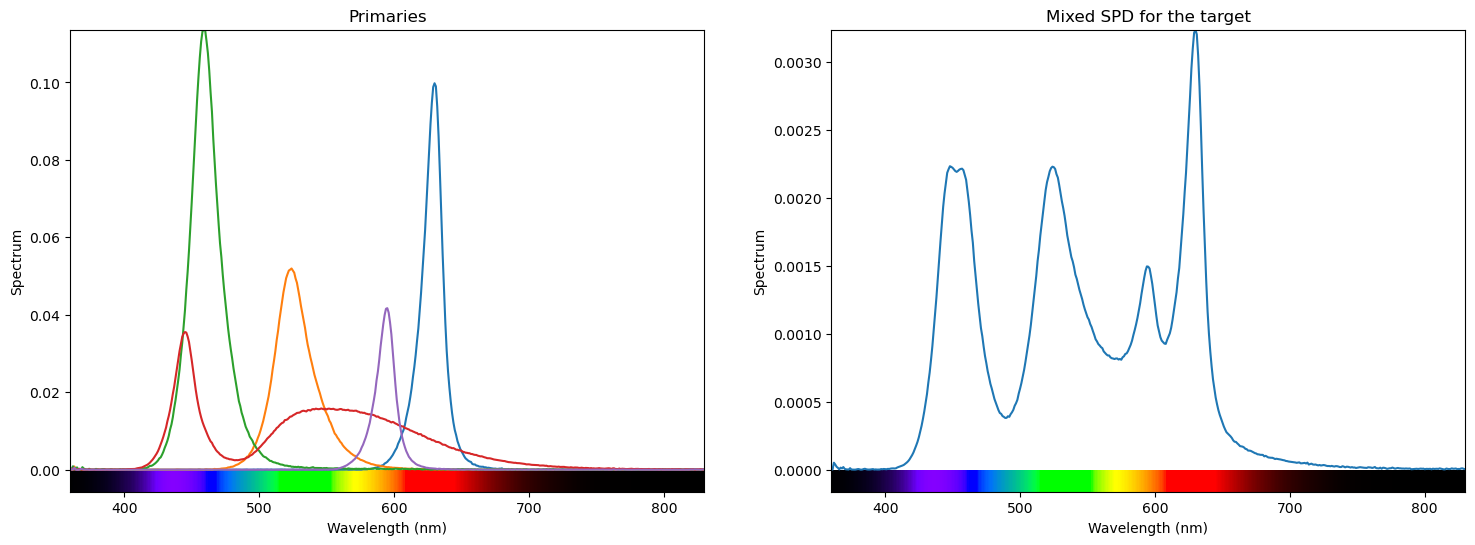

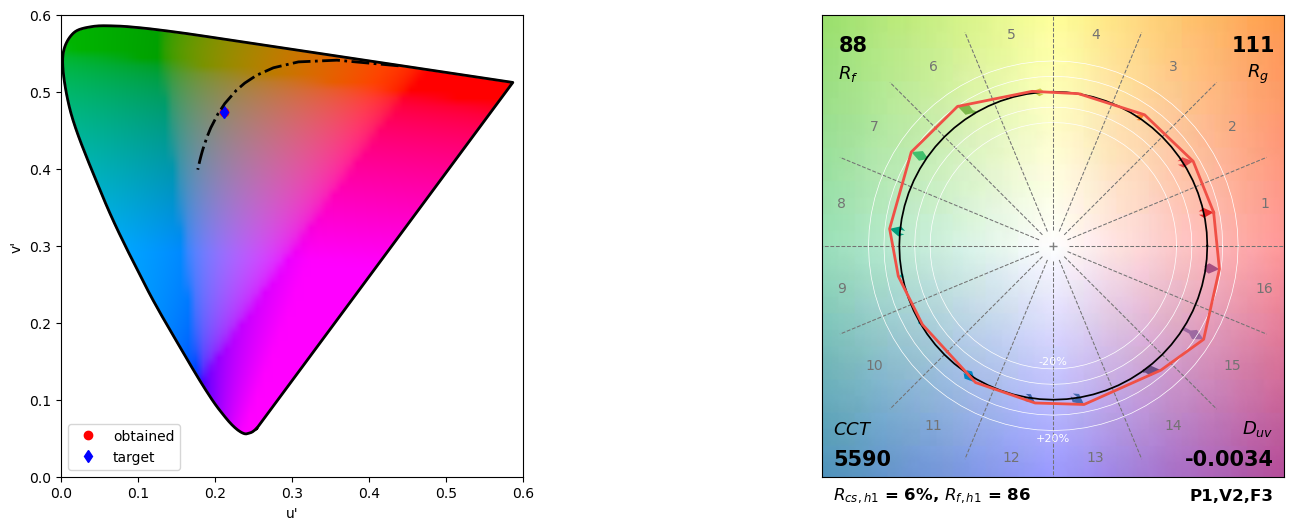

In [ ]:
xyz_t = np.array([[100, 100, 100]])*1
channels_idx = [0, 1, 2, 3, 4]
spd5 = color_mixing(xyz_t,  channels_idx)

### Multi-objective optimizer

In [ ]:
def spectralOptimization(channels_idx, target=None, tar_type='xyz', Rf_Rg=None, LER=None, method='Nelder-Mead'):
        
    methods = ['Nelder-Mead', 'particleswarm', 'demo']
    if method not in methods:
        print('Specify correct method.', methods)
        return 


    tar_types = ["xyz_t, Yxy_t, cct_t"]    
    if tar_type == 'xyz':
        xyz_t = target # for the evaluation process
    elif tar_type =='Yxy':
        
        xyz_t = lx.Yxy_to_xyz(target) # for the evaluation process
    elif tar_type == 'cct':
        
        xyz_t = lx.cct_to_xyz(target) # for the evaluation process
    else:
        print('Specify correct target type.', tar_types)
        return 

    # define function that calculates several objectives at the same time (for speed):
    def spd_to_cris(spd):
        Rf, Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30', out='Rf,Rg')
        return np.vstack((Rf, Rg))

    def spd_to_LER(spd):
        LER = lx.spd_to_ler(spd, cieobs=cieobs)
        return LER.T
    
    obj_fcn = []
    obj_tar_vals = []
    if Rf_Rg is not None:
        obj_fcn.append((spd_to_cris, 'Rf', 'Rg'))
        obj_tar_vals.append(Rf_Rg) 
    if LER is not None:
        obj_fcn.append((spd_to_LER, 'LER'))
        obj_tar_vals.append(LER) 
       

    spd_p = getPrimarySPD(channels_idx=channels_idx)
    so = spb.SpectralOptimizer(target = target,
                                tar_type = tar_type,
                                wlr = [360,830,1], 
                                cieobs = cieobs, 
                                out = 'spds,primss,Ms,results',
                                optimizer_type = '3mixer',
                                prim_constructor = None, 
                                prims = spd_p,
                                obj_fcn = spb.ObjFcns(f = obj_fcn,
                                                    ft = obj_tar_vals),
                                                    # fw = obj_fcn_weights),
                                minimizer = spb.Minimizer(method=method),
                                verbosity = 0)

    # start optimization:
    start_time = time.time()
    S, M = so.start(out='spds,Ms')
    print('Running time for the optimization: {:.2f} sec'.format(time.time()-start_time))

    driver_values = getDriverValues(channels_idx, M)
    print('Optimized primary contributions:', M[0])
    print('driver values values of the light source:', driver_values)

    def _result(spd):
        xyz = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
        Yxy = lx.xyz_to_Yxy(xyz)
        cct, duv = lx.xyz_to_cct(xyz, cieobs=cieobs, out='cct,duv')
        Rf, Rg = spd_to_cris(spd)
        res_LER = spd_to_LER(spd)

        # _cct, _duv = lx.colortf(spd, tf = 'spd>cct', 
        #                  bwtf = {'cieobs':cieobs}, 
        #                  fwtf = {'cieobs':cieobs, 'out':'cct,duv'}) # note that this is the same as a call to spd_to_xyz followed by a coll to xyz_to_cct

        print('Results (optim,target):')
        print("Rf: ({:1.2f}, {:1.2f})".format(Rf[0], np.nan if Rf_Rg is None else Rf_Rg[0]))
        print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], np.nan if Rf_Rg is None else Rf_Rg[1]))
        print("CCT [K]: ({:1.1f}, {:1.1f})".format(cct[0][0], np.nan if tar_type != 'cct' else target[0][0]))
        print("Duv: ({:1.4f}, {:1.4f})".format(duv[0][0], np.nan if tar_type != 'cct' else target[0][-1]))

        print("LER [lm/W]: ({:1.1f}, {:1.1f})".format(res_LER[0][0], np.nan if LER is None else LER))
    
    print('\n------Optimized Result-------')
    _result(S)
    showMixedSPD(spd_p, S)
    evaluate(S, xyz_t)
    
    if dmx.is_connected:
        print('\n------Measured Result-------')
        spd_measured = measureSPD(channels_idx, driver_values)
        _result(spd_measured)
        showMixedSPD(spd_p, spd_measured)
        evaluate(spd_measured, xyz_t)





Running time for the optimization: 3.60 sec
Optimized primary contributions: [6.5047e-03 3.8356e-02 5.2152e-02 1.6482e-02 5.9215e-02]
driver values values of the light source: [254  21  32   6  35]

------Optimized Result-------
Results (optim,target):
Rf: (78.88, 80.00)
Rg: (91.65, 95.00)
CCT [K]: (31724.0, nan)
Duv: (-0.0023, nan)
LER [lm/W]: (286.4, 350.0)
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 200.0 ]
Target xyz : [ 100.0, 100.0, 200.0 ]
[3.1724e+04]
CCT: 31723.997537216896
Duv: -0.0022520301350459604
Rf: 78.87624073939818
Rg: 91.64743687725739
LER: 250.87424153596737
color difference in LUV space: 1.9253610481711162e-13
JND: 0


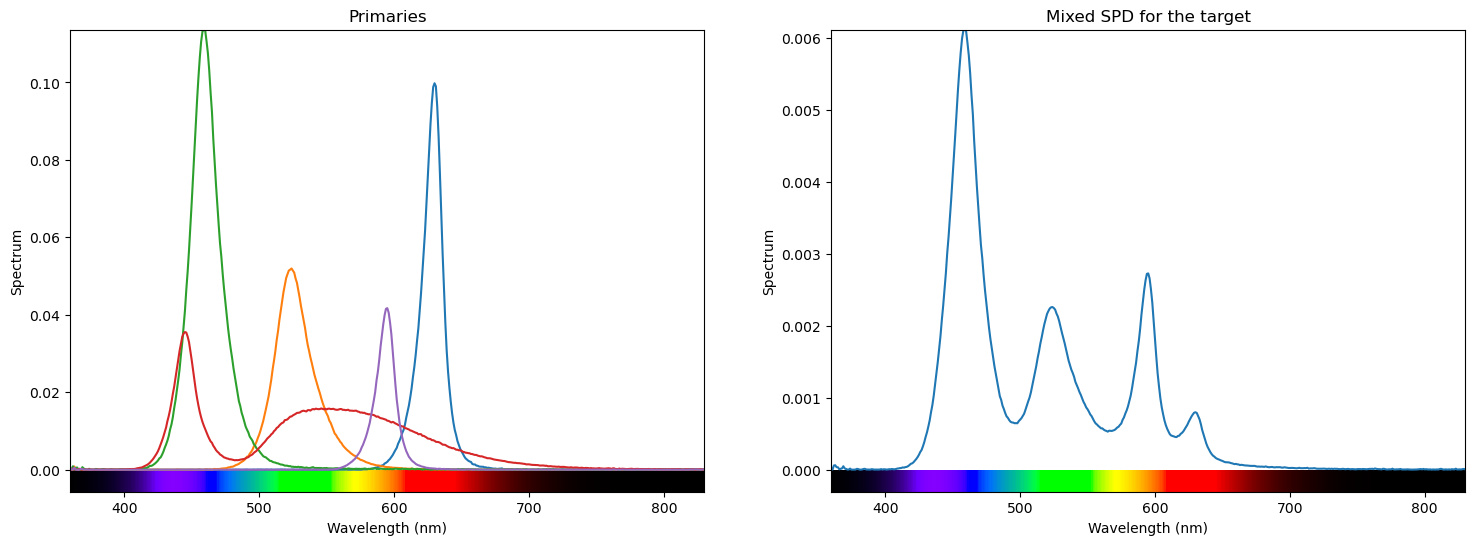

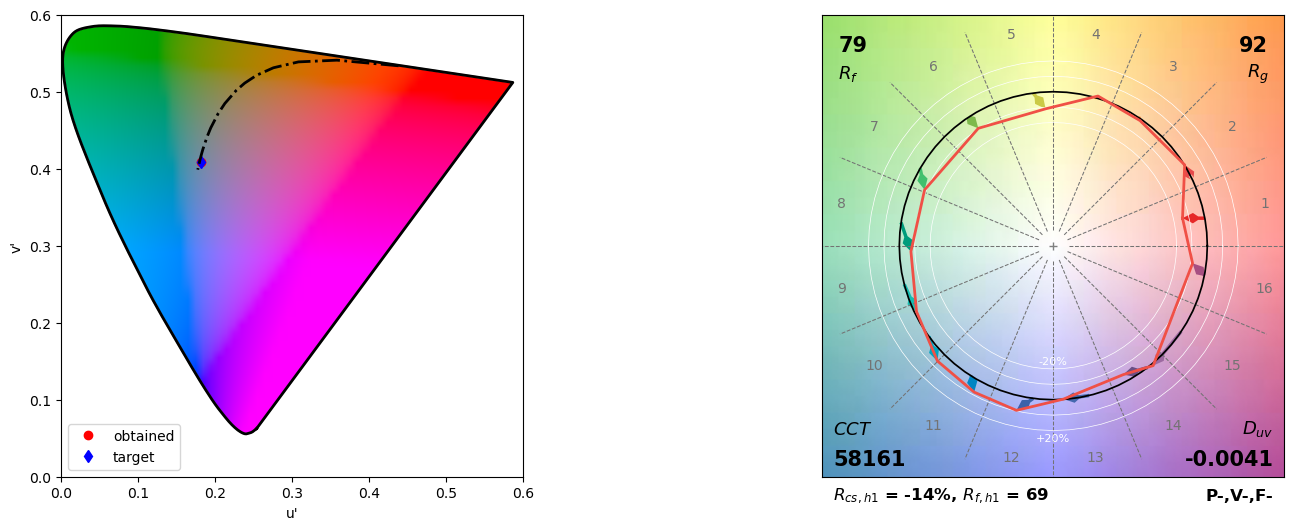

In [ ]:
# %pip show luxpy
xyz_t = np.array([[100, 100, 200]])
Yxy_t = np.array([[100,1/3,1/3]])
cct_t = np.array([[4000, -0.003]])
channels_idx = [0, 1, 2, 3, 4]

# spectralOptimization(channels_idx, xyz_t=xyz_t, Rf_Rg=(80, 95))

# spectralOptimization(channels_idx, target=xyz_t, tar_type='xyz',  LER=350, method='particleswarm')

spectralOptimization(channels_idx, target=xyz_t, tar_type='xyz',Rf_Rg=(80, 95), LER=350, method='particleswarm')


# spectralOptimization(channels_idx, xyz_t=None,
#                      Rf_Rg=(80, 95),  CCT_Duv=(6000, 0.05), LER=300, method='particleswarm')

# spectralOptimization(channels_idx, xyz_t=xyz_t,
#                      Rf_Rg=(80, 95), LER=200, method='particleswarm')

# spectralOptimization(channels_idx, xyz_t=xyz_t, LER = 400, method='particleswarm')


In [ ]:
dmx.close()

AttributeError: 'DMXHandler' object has no attribute 'set_channel'